# The Classiq Workflow

This notebook introduces the typical workflow with Classiq:
- **Designing a quantum algorithm** using the Qmod language and it's accompanied function library.
- **Synthesizing the algorithm** into a concrete circuit implementation.
- **Executing the algorithm** on a chosen simulator or quantum harware.
- **Post-processing** the results.

To get started, run:

In [10]:
from classiq import *

/Users/drorsegman/Library/Caches/pypoetry/virtualenvs/external-user-venv-PaJZMdG0-py3.11/lib/python3.11/site-packages/classiq/_internals/authentication/token_manager.py:101: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


If this `import` doesn't work for you, please try `pip install classiq` in your terminal, or refer to [Registration and Installation](https://docs.classiq.io/latest/classiq_101/registration_installations/).

## Designing a Quantum Algorithm



Here we will define a quantum function `main` that calculates a simple arithmetic expression.

Step-by-step:
1. Allocate 3 qbits for the quantum number `x`, allowing it to represent $2^3$ different numbers, from 0 to 7 (for example, the bitstring '010' represents 2).
2. Apply `hadamard_transform` on `x` to prepare it into an equal superposition of all these numbers.
3. Assign the desired arithmetic expression result into the quantum number `y`.


In [11]:
@qfunc

def main(x: Output[QNum], y: Output[QNum]) -> None:
    allocate(3,x)
    hadamard_transform(x)
    y |= x**2 + 1


We expect the output variables `x` and `y` to end in an equal superpostion of the states $|x_i\rangle |y_i=x_i^2+1\rangle$ for $x_is$ from 0 to 7.
In other words, we have designed our quantum algorithm to calculate $x^2 +1$.

## Synthesizing The Algorithm

The function `main` describes your algorithm in a high-level manner: "calculate $x^2+1$ and assign in into `y`". However, it does not specify __how__ to apply this calculation - it does not map the desired result to an executable quantum circuit, made of elementary quantum gates.\
In order to do so, you can pass your algorithm to Classiq's synthesis engine. 

First, create a Quantum Model object `qmod` out of the function `main`:

In [15]:
qmod = create_model(main)

Then, pass `qmod` to the synthesis engine to obtain a concrete quantum program `qprog`.\
Here we will simply call to the function `synthesize`. Later on you will learn to provide configuration details (for example, which elementary gates are allowed to use?) using [`set_preferences`](https://docs.classiq.io/latest/sdk-reference/synthesis/?h=set_pre#classiq.set_preferences).

In [6]:
qprog = synthesize(qmod)

str

You can analyze the resulting implementation using Classiq visualization tool:

In [17]:
show(qprog)

Opening: https://platform.classiq.io/circuit/2sZn9mvqKtfZXcWLEN8U26r0kSj?version=0.67.0


You should see something like this:

![Screenshot 2025-02-04 at 14.51.53.png](<attachment:Screenshot 2025-02-04 at 14.51.53.png>)
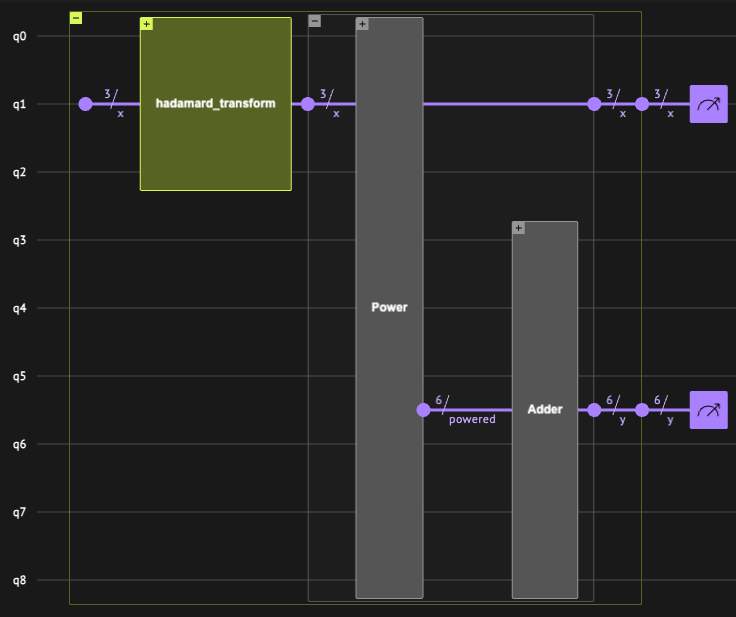

By clicking the `+` icons on the blocks' top-left corner, you can inspect the gate-level implementation of each functional block. For example, inspect the complex combination of `H`, `CPHASE`, `CX` and `U` gates that implements the `Power` block.

## Executing The Quantum Program
Now that we have a concrete circuit implementation of the desired algorithm, we can execute it and sample the resulting states of the output variables.\
Here we will simply call the function `execute`, which uses Classiq's default quantum simulator, and samples the variable with the default `n_shots`=2048 times:

In [18]:
job = execute(qprog)

Later on you will learn how to execute on hardwares and simulators of your choice and manage advanced executions (for example, hybrid execution that uses classical logic to alter the circuit between runs).

## Post-processing The Results

Having executed the quantum program multiple times (`n_shots`=2048) we can now inspect the possible pairs `x`,`y` that our arithmetic expression allows ($y=x^2+1$).\
This can be done by looking into `parsed_counts` - a list of all the states that were measured on the output variables, ordered by the number of shots (counts) that they were measured.

In [25]:
pc = job.get_sample_result().parsed_counts
print(pc)

[{'x': 6, 'y': 37}: 280, {'x': 4, 'y': 17}: 273, {'x': 0, 'y': 1}: 267, {'x': 3, 'y': 10}: 260, {'x': 1, 'y': 2}: 258, {'x': 5, 'y': 26}: 248, {'x': 2, 'y': 5}: 238, {'x': 7, 'y': 50}: 224]


As expected, all possible values of `x` (integers from 0 to 7) were measured roughly similar amount of times, and with each `x` measured, the measurement of `y` satisfies $y=x^2+1$.

Alternatively, you can inspect the histogram of sampled states in Classiq's web platform:

In [29]:
job.open_in_ide()

![Screenshot 2025-02-05 at 9.14.35.png](<attachment:Screenshot 2025-02-05 at 9.14.35.png>)
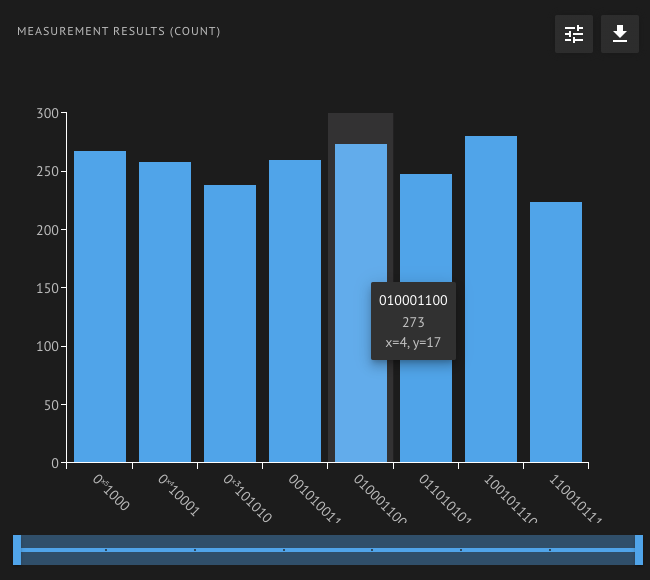

Hovering above each of the histogram bars shows its bitstring and its parsed variables values. For example, the bistring '010001100' is parsed into `x`=4, `y`=17, because the first 3 qubits (counting from the right, or the LSB) were allocated to `x` and were measured '100'=4, and the 6 qubits allocaled for `y` (automatically, by the synthesis engine) were measured '010001'=17.

## Summary

In this tutorial, we have gone through a typical workflow using Classiq:
1. Modeling a quantum algorithm: the problem we wanted to solve is calculating an arithmetic expression for a given domain of `x` values. We used `hadamard_transform` and arithmetic assignment as our modeling building blocks.
2. Synthesizing the model into a concrete circuit implementation: we called `synthesize` to let Classiq's synthesis engine take our high-level description of algorithm and implement it in an executable way.
3. Executing the algorithm: we called `execute` to run our quantum program multiple times on Classiq's simulator.
4. Post-processing: We inspected the measured states of `x` and `y` and assured ourselves that they satisfy the desired arithmetic expression.

Note: 

You might have noticed that our algorithm does not truely harness the power of quantum computers: a moment before sampling the qubits, `x` and `y` indeed hold "the answers to all questions" simultaneously (all the pairs `x` and `y` that satisfy the equation), but we cannot access these answers unless sampling the qubits, which collapsese the superposition and leaves only  a single (and randomly chosen) pair of `x` and `y`.\
Having said that, we have no choice but to run multiple times (many more than $2^3$ in our case) to make sure that we measure all `x`s of interest. A classical computer could obtain the same information in exactly $2^3$ runs.\ 
Then, why bother?\
Pure arithmetic will probably never be a mission for quantum computers. However, arithmetics are an essential building block in multiple quantum algorithms (...) 




***note on the fact that it is not a useful quantum algo but a building block...
***fix images

## Practice
Edit the arithmetic expression inside `main`, using the `+`, `-`, `**` operators as well as literal numbers of your choice. Validate that the sampled states of `x` and `y` satsify your arithmetic expression.
